# Deep Learning - **Tutorial #1**

* Teching assistant email: trung@uef.fi
* Slide with results and explaination: [bit.ly/2qTJZ5S](https://bit.ly/2qTJZ5S)
* Notebook: [bit.ly/2KnGJ9S](https://bit.ly/2KnGJ9S)
* Full source code: [bit.ly/2NO0uJA](https://bit.ly/2NO0uJA)

Goals:

* Does deep network “understand”?
* Handling uncertainty in the inputs.
* Blackbox model is both fun and dangerous
* Dreaming about fashion with deep network.

**NOTE**: no grading, just practicing

In [0]:
# All libraries we use for this Tutorial, run this block first!
%tensorflow_version 2.x
import os

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

TensorFlow 2.x selected.


In [0]:
#@title Functions for visualization (run this block)
def show_sample_images(images,
                       labels=None,
                       n=5,
                       labels_name=None,
                       seed=8,
                       axes=None,
                       interpolation=None,
                       shuffle=True):
  from matplotlib import pyplot as plt
  from itertools import chain
  if labels is not None and labels.ndim == 2:
    labels = np.argmax(labels, axis=1)
  np.random.seed(seed)
  if shuffle:
    indices = np.random.permutation(len(images))
  else:
    indices = np.arange(len(images), dtype='int32')
  if axes is None:
    n_images = len(images)
    nrows = n if n_images > n else 1
    ncols = min(n, n_images)
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=(int(ncols * 1.2), int(nrows * 1.2) + 1))
  if isinstance(axes[0], (np.ndarray, tuple, list)):
    axes = chain(*axes)
  elif not isinstance(axes, (np.ndarray, tuple, list)):
    axes = [axes]
  fig_images = []
  for count, ax in enumerate(axes):
    ax.axis('off')
    if count >= len(indices):
      continue
    idx = indices[count]
    img = images[idx]
    cmap = 'Greys'
    if img.ndim == 1:
      dim = int(np.sqrt(len(img)))
      img = img.reshape(dim, dim)
    elif img.ndim == 3 and img.shape[-1] == 1:
      img = np.squeeze(img, axis=-1)
    else:
      cmap = None
    fig_images.append(ax.imshow(img, cmap=cmap, interpolation=interpolation))
    if labels is not None:
      lab = labels[idx] if labels_name is None else \
        labels_name[int(labels[idx])]
      ax.set_title(lab, fontsize=8)
  return fig_images


def show_animation(images_list,
                   labels=None,
                   n=5,
                   labels_name=None,
                   fps=1.5,
                   seed=8,
                   delta=False,
                   cmap=None,
                   interpolation=None):
  from matplotlib import pyplot as plt
  import matplotlib.animation as animation
  from itertools import chain
  # ims is a list of lists, each row is a list of artists to draw in the
  # current frame; here we are just animating one artist, the image, in
  # each frame
  ims = []
  # images_list is list of image list
  if isinstance(images_list[0], (tuple, list)):
    # have to reuse the same axes
    n_images = len(images_list[0])
    nrows = n if n_images > n else 1
    ncols = min(n, n_images)
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=(int(ncols * 1.2), int(nrows * 1.2)))
    for images in images_list:
      ims.append(
          show_sample_images(images,
                             labels,
                             n=n,
                             labels_name=labels_name,
                             seed=seed,
                             axes=axes))
  # single image
  else:
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    img_generator = [img2 - img1
                     for img1, img2 in zip(images_list, images_list[1:])] \
      if delta else images_list
    vmin = np.min([np.min(i) for i in img_generator])
    vmax = np.max([np.max(i) for i in img_generator])
    for img in img_generator:
      img = ax.imshow(
          img,
          cmap='Blues' if cmap is None else cmap,
          interpolation='bilinear' if interpolation is None else interpolation,
          vmin=vmin,
          vmax=vmax)
      ax.axis('off')
      ims.append([img])
  #
  ani = animation.ArtistAnimation(
      fig,
      ims,
      interval=1 / fps * 1000,  # in millisecond
      blit=True,
      repeat=False,
      repeat_delay=1000)
  return ani


def show_misclassification(images,
                           y_true,
                           y_pred,
                           n=5,
                           labels_name=None,
                           title=None):
  if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)
  if y_pred.ndim == 2:
    y_pred = np.argmax(y_pred, axis=1)
  indices = np.asarray(y_true) != np.asarray(y_pred)
  if np.sum(indices) == 0:
    return
  images = images[indices]
  y_true = y_true[indices]
  y_pred = y_pred[indices]
  labels = np.array([
      "True:%s\nPred:%s" %
      ((str(true), str(pred)) if labels_name is None else
       (str(labels_name[int(true)]), str(labels_name[int(pred)])))
      for true, pred in zip(y_true, y_pred)
  ])
  show_sample_images(images=images, labels=labels, n=n, labels_name=None)
  if title is not None:
    plt.suptitle(str(title))


def show_confusion_matrix(y_true, y_pred, labels=None, title=None, ax=None):
  from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
  import seaborn as sns
  from matplotlib import pyplot as plt
  if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)
  if y_pred.ndim == 2:
    y_pred = np.argmax(y_pred, axis=1)
  if labels is None:
    labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = ['#%d' % i for i in sorted(labels)]
  cm = confusion_matrix(y_true, y_pred)
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  if ax is None:
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
  elif isinstance(ax, (tuple, list)):
    ax = plt.subplot(*ax)
  sns.heatmap(cm,
              cmap='Blues',
              annot=True,
              fmt="d",
              linewidths=.2,
              xticklabels=labels,
              yticklabels=labels,
              cbar=False,
              ax=ax)
  plt.title("%sAccuracy:%.2f  F1-score:%.2f" %
            (('[%s]' % str(title)) if title is not None else '', acc, f1))


def evaluate_classifier(model,
                        X_train,
                        y_train,
                        X_test,
                        y_test,
                        labels_name=None):
  plt.figure(figsize=(18, 5))
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  show_confusion_matrix(y_true=y_train,
                        y_pred=y_train_pred,
                        title='Train',
                        labels=labels_name,
                        ax=(1, 2, 1))
  show_confusion_matrix(y_true=y_test,
                        y_pred=y_test_pred,
                        title='Test',
                        labels=labels_name,
                        ax=(1, 2, 2))
  show_misclassification(images=X_train,
                         y_true=y_train,
                         y_pred=y_train_pred,
                         labels_name=labels_name,
                         title='Train')
  show_misclassification(images=X_test,
                         y_true=y_test,
                         y_pred=y_test_pred,
                         labels_name=labels_name,
                         title='Test')

In [0]:
#@title Functions for downloading the data (run this block)
def download_images(target_size=None):
  import base64
  url = b'aHR0cHM6Ly9haS1kYXRhc2V0cy5zMy5hbWF6b25hd3MuY29tL3N0ZXRpbmQuanBlZw==\n'
  url = str(base64.decodebytes(url), 'utf-8')
  name = os.path.basename(url)
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return np.array(img)


def deprocess(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)


def download_fmnist():
  import tensorflow_datasets as tfds
  train = tfds.load('fashion_mnist', split='train')
  test = tfds.load('fashion_mnist', split='test')

  X_train, y_train = [], []
  for data in train.batch(256):
    X_train.append(data['image'].numpy().astype('float32'))
    y_train.append(data['label'].numpy().astype('float32'))
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)

  X_test, y_test = [], []
  for data in test.batch(256):
    X_test.append(data['image'].numpy().astype('float32'))
    y_test.append(data['label'].numpy().astype('float32'))
  X_test = np.concatenate(X_test, axis=0)
  y_test = np.concatenate(y_test, axis=0)

  X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
  X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))
  return dict(X_train=X_train,
              y_train=y_train,
              X_test=X_test,
              y_test=y_test,
              labels_name=np.array([
                  'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
              ]))


def download_digits():
  from six.moves.urllib.request import urlretrieve
  import base64
  url = b'aHR0cHM6Ly9haS1kYXRhc2V0cy5zMy5hbWF6b25hd3MuY29tL2RpZ2l0cy5ucHo=\n'
  urlretrieve(str(base64.decodebytes(url), 'utf-8'), 'digits.npz')
  return {i: j for i, j in np.load('digits.npz').items()}

# Part I: What does artificial neural network learn?

## a) Make MNIST work again

X_train        : float32 (1437, 64)
X_train_dot    : float32 (1437, 64)
X_train_shift  : float32 (1437, 256)
X_test         : float32 (360, 64)
X_test_shift   : float32 (360, 256)
y_train        : int32 (1437,)
y_test         : int32 (360,)


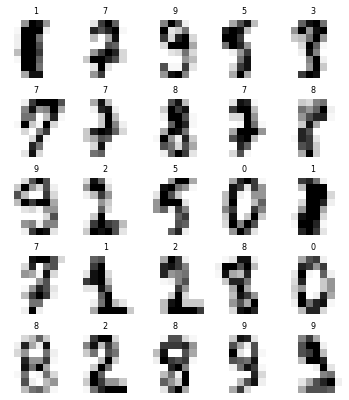

In [0]:
dataset = download_digits()
for i, j in dataset.items():
  print('%-15s:' % i, j.dtype, j.shape)

X_train = dataset['X_train']
y_train = dataset['y_train']
X_test = dataset['X_test']
y_test = dataset['y_test']
_ = show_sample_images(images=X_train, labels=y_train, n=5)

Train on 1149 samples, validate on 288 samples
Epoch 1/12
1149/1149 [==============================] - 1s 1ms/sample - loss: 2.3059 - accuracy: 0.1192 - val_loss: 2.2086 - val_accuracy: 0.1701
Epoch 2/12
1149/1149 [==============================] - 0s 42us/sample - loss: 2.1393 - accuracy: 0.3020 - val_loss: 2.0506 - val_accuracy: 0.4965
Epoch 3/12
1149/1149 [==============================] - 0s 35us/sample - loss: 1.9737 - accuracy: 0.5300 - val_loss: 1.8703 - val_accuracy: 0.6111
Epoch 4/12
1149/1149 [==============================] - 0s 34us/sample - loss: 1.7782 - accuracy: 0.6571 - val_loss: 1.6516 - val_accuracy: 0.7049
Epoch 5/12
1149/1149 [==============================] - 0s 33us/sample - loss: 1.5502 - accuracy: 0.7363 - val_loss: 1.4131 - val_accuracy: 0.7674
Epoch 6/12
1149/1149 [==============================] - 0s 35us/sample - loss: 1.3144 - accuracy: 0.8268 - val_loss: 1.1699 - val_accuracy: 0.8403
Epoch 7/12
1149/1149 [==============================] - 0s 33us/sample -

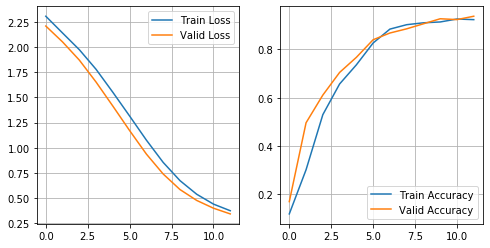

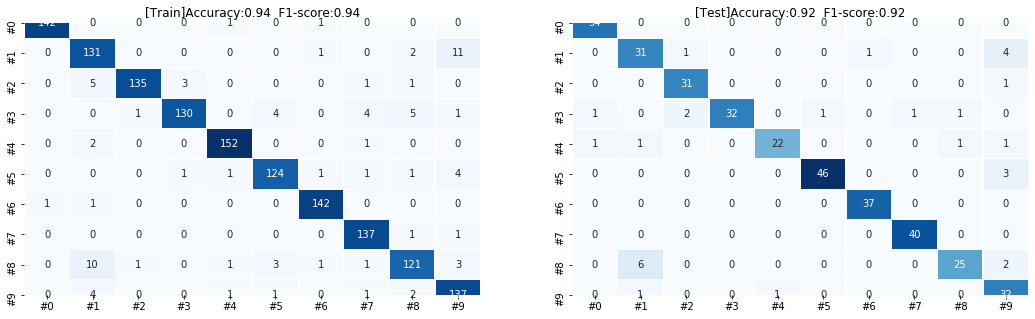

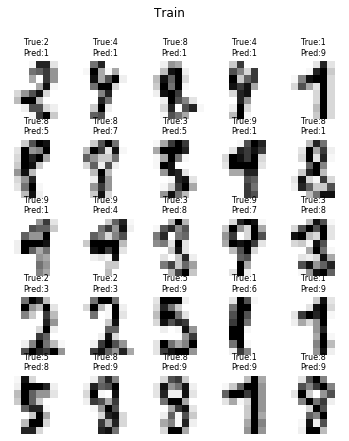

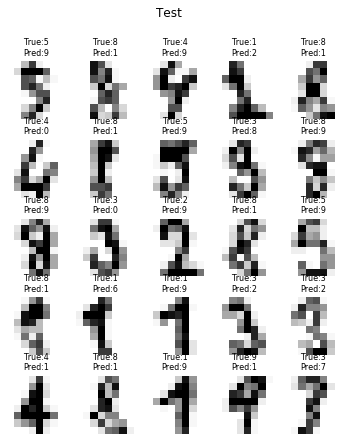

In [0]:
# you have two option to fix the issue:
# * Using one-hot encoded for y_train
# * Using "sparse_categorical_crossentropy" for loss
X_train = X_train / np.max(X_train)
y_train = tf.one_hot(y_train, 10).numpy()

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=12,
    validation_split=0.2,
)

# ====== show the learning curve ====== #
history = model.history.history
train_loss = history['loss']
valid_loss = history['val_loss']
train_acc = history['accuracy']
valid_acc = history['val_accuracy']
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Valid Loss")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(valid_acc, label="Valid Accuracy")
plt.legend()
plt.grid()

# ====== evaluating the classifier ====== #
_ = evaluate_classifier(model, X_train, y_train, X_test, y_test)

## b) Does the network understand arithmetic?

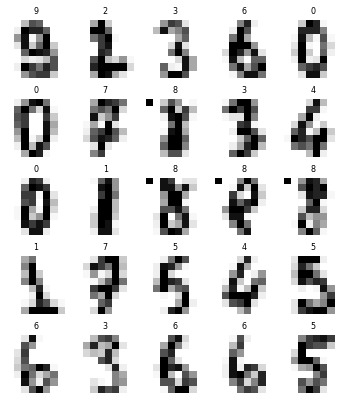

In [0]:
# loading another MNIST for training
X_train = dataset['X_train_dot']
# this time we split the training data into train and valid ourself
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.2)
_ = show_sample_images(X_train, y_train)

In [0]:
# Create the model, prepare the optimization and loss function
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
fn_loss = keras.losses.categorical_crossentropy

In [0]:
# This time we train the network ourself without the help of keras
# Also during the training we record the change in the hidden activations
# and the parameters of the network
total_iter = 0
n_epoch = 25
batch_size = 64

hidden_images1 = []
hidden_images2 = []
kernel_images = []

for epoch in range(n_epoch):
  for batch_start in range(0, X_train.shape[0], batch_size):
    x = X_train[batch_start:batch_start + batch_size]
    y_true = y_train[batch_start:batch_start + batch_size]
    with tf.GradientTape() as tape:
      y_pred = model(x)
      loss = tf.reduce_mean(fn_loss(y_true, y_pred))
    # get the gradients
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients([
        (g, v) for g, v in zip(grads, model.trainable_variables)
    ])
    # store the kernel (i.e. the weight)
    kernel_images.append(
        [l.kernel.numpy() for l in model.layers if hasattr(l, 'kernel')])
    # monitoring the training
    total_iter += 1
    if total_iter % 10 == 0:
      y_train_pred = model(X_train).numpy()
      train_acc = accuracy_score(y_true=np.argmax(y_train, axis=1),
                                 y_pred=np.argmax(y_train_pred, axis=1))
      y_valid_pred = model(X_valid).numpy()
      valid_acc = accuracy_score(y_true=np.argmax(y_valid, axis=1),
                                 y_pred=np.argmax(y_valid_pred, axis=1))
      print("Iter#%d Loss:%.4f Train_acc:%.4f Valid_acc:%.4f" %
            (total_iter, loss.numpy(), train_acc, valid_acc))
    # record everything first 10 iteration
    if total_iter < 50 or total_iter % 5 == 0:
      # store hidden activation images
      h1 = model.layers[0](X_valid)
      h2 = model.layers[1](h1)
      # convert to list of images
      hidden_images1.append([i for i in h1.numpy()])
      hidden_images2.append([i for i in h2.numpy()])

Iter#10 Loss:1.7819 Train_acc:0.4230 Valid_acc:0.4514
Iter#20 Loss:1.1660 Train_acc:0.6188 Valid_acc:0.6424
Iter#30 Loss:0.8442 Train_acc:0.7833 Valid_acc:0.8056
Iter#40 Loss:0.6653 Train_acc:0.8625 Valid_acc:0.8646
Iter#50 Loss:0.2832 Train_acc:0.9095 Valid_acc:0.9028
Iter#60 Loss:0.2183 Train_acc:0.9304 Valid_acc:0.9410
Iter#70 Loss:0.1379 Train_acc:0.9574 Valid_acc:0.9410
Iter#80 Loss:0.2433 Train_acc:0.9678 Valid_acc:0.9444
Iter#90 Loss:0.0901 Train_acc:0.9791 Valid_acc:0.9549
Iter#100 Loss:0.0732 Train_acc:0.9852 Valid_acc:0.9688
Iter#110 Loss:0.0506 Train_acc:0.9887 Valid_acc:0.9722
Iter#120 Loss:0.0411 Train_acc:0.9896 Valid_acc:0.9722
Iter#130 Loss:0.0753 Train_acc:0.9930 Valid_acc:0.9722
Iter#140 Loss:0.0353 Train_acc:0.9956 Valid_acc:0.9688
Iter#150 Loss:0.0308 Train_acc:0.9974 Valid_acc:0.9757
Iter#160 Loss:0.0221 Train_acc:0.9983 Valid_acc:0.9618
Iter#170 Loss:0.0562 Train_acc:0.9983 Valid_acc:0.9722
Iter#180 Loss:0.0168 Train_acc:0.9991 Valid_acc:0.9653
Iter#190 Loss:0.014

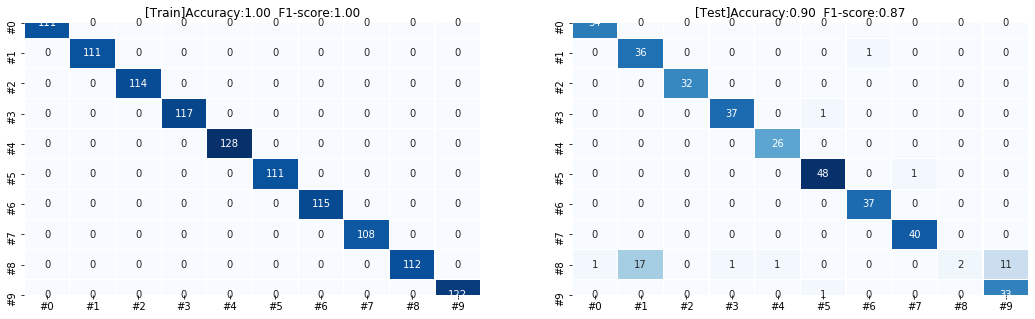

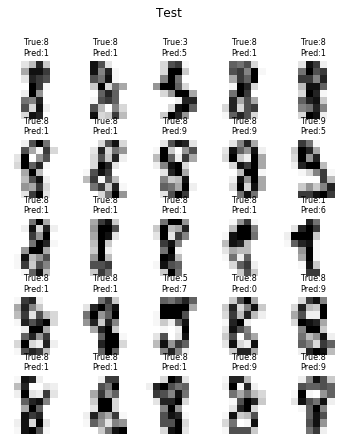

In [0]:
# Evaluating our classifier against the test set
# something wrong with number 8?
_ = evaluate_classifier(model, X_train, y_train, X_test, y_test)

In [0]:
#@title this code block will generate the animation how the parameters and activations change during training but they won't work on Google Colab
ani = show_animation([k[0] for k in kernel_images], fps=12, delta=False)
ani = show_animation([k[0] for k in kernel_images], fps=12, delta=True)
ani = show_animation(hidden_images1,
                     labels=np.argmax(y_valid, -1),
                     fps=20,
                     delta=False)
ani = show_animation(hidden_images2,
                     labels=np.argmax(y_valid, -1),
                     fps=20,
                     delta=False)


Text(0.5, 0.98, 'Activation Last Epoch')

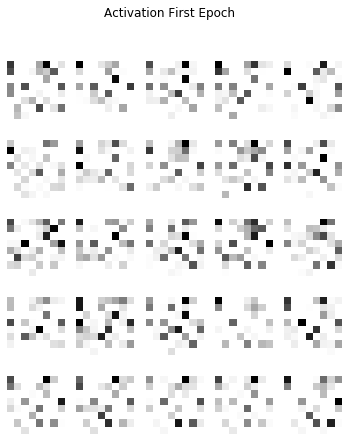

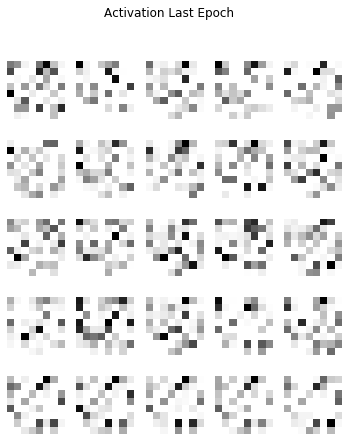

In [0]:
show_sample_images(hidden_images1[0]); plt.suptitle("Activation First Epoch")
_ = show_sample_images(hidden_images1[-1]); plt.suptitle("Activation Last Epoch")

# Part II: Handling uncertainty with Attention based model

![alt text](https://drive.google.com/uc?export=view&id=1lfPXoRZVlnyjHjW1CwmH8qH-IIhPdBS9)

More detail: 

* https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
* https://jalammar.github.io/illustrated-gpt2/

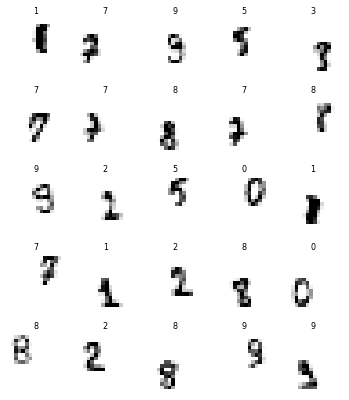

In [0]:
X_train = dataset['X_train_shift']
y_train = dataset['y_train']
X_test = dataset['X_test_shift']
y_test = dataset['y_test']
_ = show_sample_images(X_train, y_train)

In [0]:
class SelfAttention(keras.layers.Layer):

  def __init__(self, units):
    super().__init__()
    self.units = units

  def build(self, input_shape):
    super().build(input_shape)
    self.kernel = self.add_weight('kernel',
                                  shape=[1, self.units],
                                  initializer='glorot_uniform',
                                  dtype=self.dtype,
                                  trainable=True)
    self.bias = self.add_weight('bias',
                                shape=(self.units,),
                                initializer='zeros',
                                dtype=self.dtype,
                                trainable=True)
    self.kernel1 = self.add_weight('kernel',
                                   shape=[self.units, 1],
                                   initializer='glorot_uniform',
                                   dtype=self.dtype,
                                   trainable=True)
    self.bias1 = self.add_weight('bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 dtype=self.dtype,
                                 trainable=True)

  def call(self, inputs):
    x = tf.expand_dims(inputs, axis=-1)
    alpha = tf.nn.relu(x @ self.kernel + self.bias)
    alpha = alpha @ self.kernel1 + self.bias1
    alpha = tf.squeeze(alpha, axis=-1)
    attention = tf.nn.softmax(alpha, axis=-1)
    outputs = inputs * attention + inputs
    return tf.concat([outputs, attention], axis=-1)

In [0]:
# Training our network with attention-mechanism
model = keras.Sequential([
    SelfAttention(64),
    # NOTE: we concatenate the attended output and the attention probabilities,
    # but during training we only need the attended output, so we split it, then only
    # take the first one
    keras.layers.Lambda(lambda x: tf.split(x, 2, axis=-1)[0]),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=12,
    validation_split=0.2,
)

Train on 1149 samples, validate on 288 samples
Epoch 1/12
1149/1149 [==============================] - 1s 551us/sample - loss: 2.8047 - accuracy: 0.1323 - val_loss: 2.2953 - val_accuracy: 0.1910
Epoch 2/12
1149/1149 [==============================] - 0s 46us/sample - loss: 1.9263 - accuracy: 0.3446 - val_loss: 2.1571 - val_accuracy: 0.2778
Epoch 3/12
1149/1149 [==============================] - 0s 49us/sample - loss: 1.5359 - accuracy: 0.5544 - val_loss: 1.9545 - val_accuracy: 0.3646
Epoch 4/12
1149/1149 [==============================] - 0s 45us/sample - loss: 1.1637 - accuracy: 0.7111 - val_loss: 1.7939 - val_accuracy: 0.4201
Epoch 5/12
1149/1149 [==============================] - 0s 46us/sample - loss: 0.8470 - accuracy: 0.8120 - val_loss: 1.6638 - val_accuracy: 0.4722
Epoch 6/12
1149/1149 [==============================] - 0s 59us/sample - loss: 0.5693 - accuracy: 0.8973 - val_loss: 1.5495 - val_accuracy: 0.5000
Epoch 7/12
1149/1149 [==============================] - 0s 42us/sample

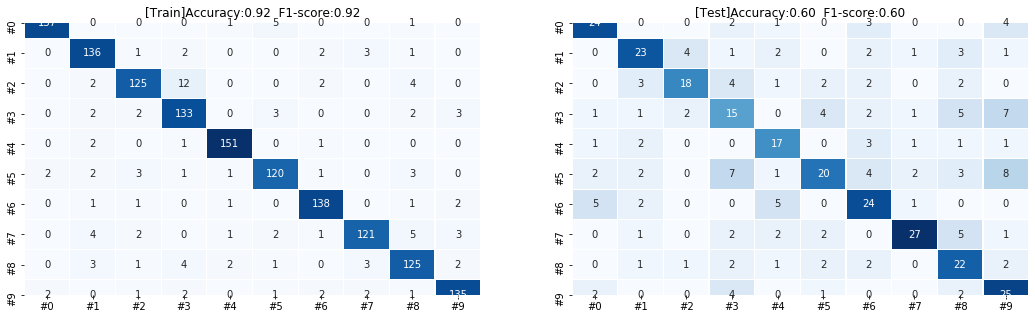

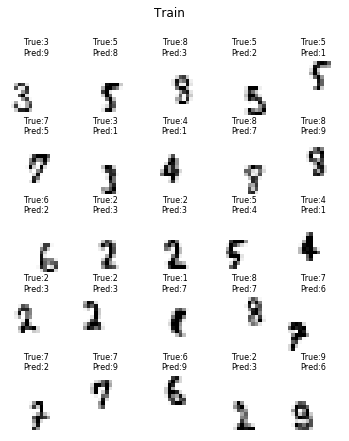

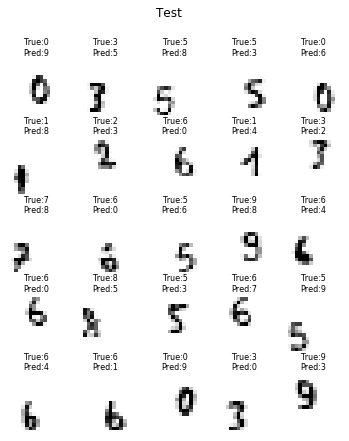

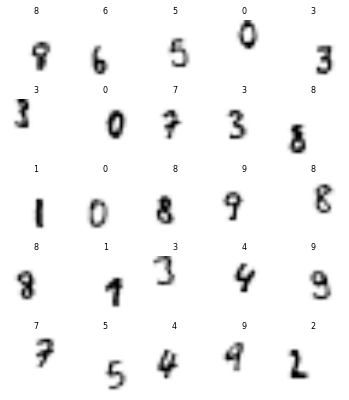

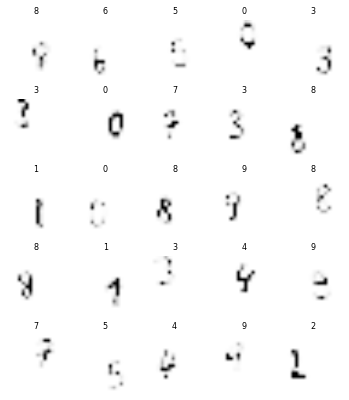

In [0]:
# evaluating our network and show the attention
evaluate_classifier(model, X_train, y_train, X_test, y_test)
model_att = keras.Sequential(
    model.layers[:1] +
    [keras.layers.Lambda(lambda x: tf.split(x, 2, axis=-1)[1])])
att = model_att(X_test).numpy()
show_sample_images(X_test, y_test, interpolation='bilinear')
_ = show_sample_images(att, y_test, interpolation='bilinear')

# Part III: Fahsion-MNIST, adversarial attack and neural network manipulation

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.
X_train float32 (60000, 784)
y_train float32 (60000,)
X_test float32 (10000, 784)
y_test float32 (10000,)
labels_name <U11 (10,)
['T-shirt/top' 'Trouser' 'Pullover' 'Dress' 'Coat' 'Sandal' 'Shirt'
 'Sneaker' 'Bag' 'Ankle boot']


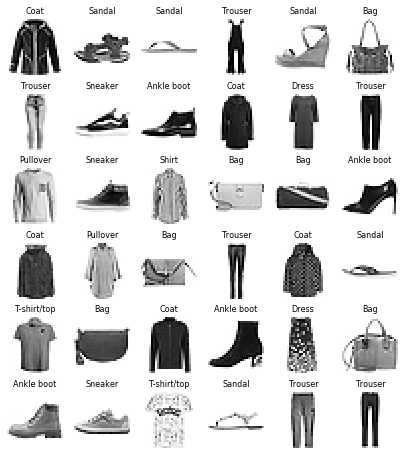

In [0]:
# Load fashion MNIST dataset
dataset = download_fmnist()
for name, value in dataset.items():
  print(name, value.dtype, value.shape)
X_train = dataset['X_train']
y_train = dataset['y_train']
X_test = dataset['X_test']
y_test = dataset['y_test']
labels_name = dataset['labels_name']
y_train = tf.one_hot(y_train.astype('int32'), 10).numpy()
print(labels_name)
img_dim = int(np.sqrt(X_train.shape[1]))
_ = show_sample_images(X_train, y_train, labels_name=dataset['labels_name'], n=6)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 25us/sample - loss: 6.1660 - accuracy: 0.7561 - val_loss: 0.7952 - val_accuracy: 0.8033
Epoch 2/25
48000/48000 [==============================] - 1s 16us/sample - loss: 0.5791 - accuracy: 0.8310 - val_loss: 0.5417 - val_accuracy: 0.8347
Epoch 3/25
48000/48000 [==============================] - 1s 16us/sample - loss: 0.4497 - accuracy: 0.8515 - val_loss: 0.5471 - val_accuracy: 0.8312
Epoch 4/25
48000/48000 [==============================] - 1s 16us/sample - loss: 0.3777 - accuracy: 0.8700 - val_loss: 0.4871 - val_accuracy: 0.8445
Epoch 5/25
48000/48000 [==============================] - 1s 16us/sample - loss: 0.3305 - accuracy: 0.8809 - val_loss: 0.4790 - val_accuracy: 0.8453
Epoch 6/25
48000/48000 [==============================] - 1s 15us/sample - loss: 0.3083 - accuracy: 0.8894 - val_loss: 0.4735 - val_accuracy: 0.8478
Epoch 7/25
48000/48000 [==============================] 

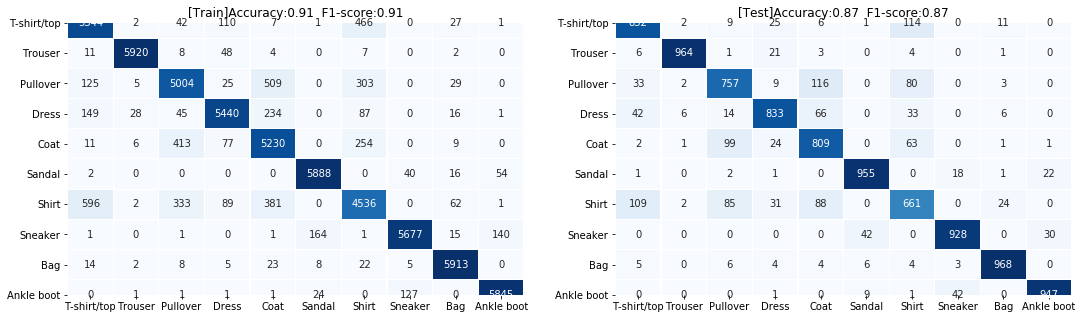

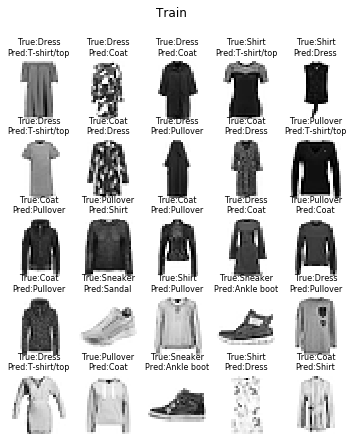

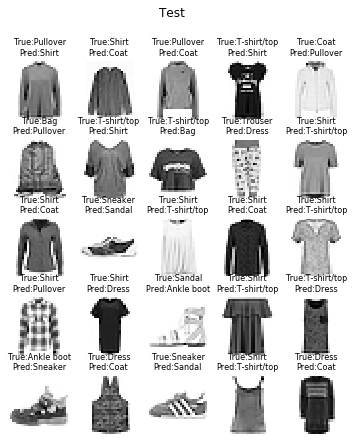

In [0]:
# We just train a decent network for F-MNIST
model = keras.Sequential([
    keras.layers.Dense(512,
                       activation='relu',
                       name='L1',
                       input_shape=X_train.shape[1:]),
    keras.layers.Dense(512, activation='relu', name='L2'),
    keras.layers.Dense(512, activation='relu', name='L3'),
    keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.fit(
    x=X_train,
    y=y_train,
    batch_size=256,
    epochs=25,
    validation_split=0.2,
    verbose=1,
)
_ = evaluate_classifier(model, X_train, y_train, X_test, y_test, labels_name)

## a) Creating adversarial example
![alt text](https://drive.google.com/uc?export=view&id=18NFi9Tpz6vTzTgKV1Y0oHwOcvQbRrqXG)

In [0]:
X_adversarial = tf.Variable(np.random.randn(1, X_train.shape[1]),
                            dtype='float32',
                            trainable=True)
print("Adversarial prediction:",
      ['%.2f' % i for i in model(X_adversarial).numpy().ravel()])

opt = tf.optimizers.Adam(learning_rate=0.01)
# everything to number 'Bag'
y_target = tf.convert_to_tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
                                dtype='float32')
fn_ce = keras.losses.categorical_crossentropy

adversarial_images = []
for epoch in range(200):
  with tf.GradientTape() as tape:
    y_adversarial = model(X_adversarial)
    loss = tf.reduce_mean(fn_ce(y_target, y_adversarial))
  grad = tape.gradient(loss, X_adversarial)
  opt.apply_gradients([(grad, X_adversarial)])
  if epoch % 10 == 0:
    print("Epoch#%d  Adversarial_Loss:%.4f" % (epoch, loss))

  img = np.squeeze(X_adversarial.numpy(), axis=0)
  dim = int(np.sqrt(X_train.shape[1]))
  img = img.reshape(dim, dim)
  adversarial_images.append(img)
print("Adversarial prediction:",
      ['%.2f' % i for i in model(X_adversarial).numpy().ravel()])

Adversarial prediction: ['0.08', '0.08', '0.08', '0.08', '0.04', '0.39', '0.08', '0.09', '0.06', '0.02']
Epoch#0  Adversarial_Loss:2.7991
Epoch#10  Adversarial_Loss:2.0682
Epoch#20  Adversarial_Loss:1.6241
Epoch#30  Adversarial_Loss:1.3183
Epoch#40  Adversarial_Loss:1.0563
Epoch#50  Adversarial_Loss:0.8224
Epoch#60  Adversarial_Loss:0.6108
Epoch#70  Adversarial_Loss:0.4476
Epoch#80  Adversarial_Loss:0.3251
Epoch#90  Adversarial_Loss:0.2411
Epoch#100  Adversarial_Loss:0.1789
Epoch#110  Adversarial_Loss:0.1346
Epoch#120  Adversarial_Loss:0.1051
Epoch#130  Adversarial_Loss:0.0851
Epoch#140  Adversarial_Loss:0.0706
Epoch#150  Adversarial_Loss:0.0597
Epoch#160  Adversarial_Loss:0.0513
Epoch#170  Adversarial_Loss:0.0443
Epoch#180  Adversarial_Loss:0.0384
Epoch#190  Adversarial_Loss:0.0337
Adversarial prediction: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.97', '0.00']


Text(0.5, 1.0, "Optimized 'bag' image")

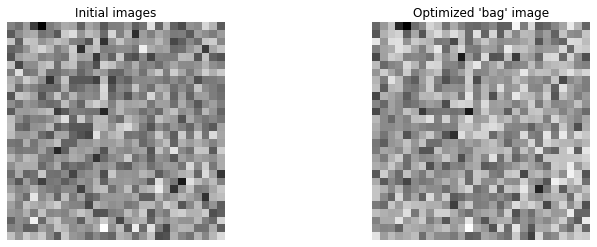

In [0]:
# showing the different before and after adversarial training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(adversarial_images[0], cmap='Greys')
plt.axis('off'); plt.title("Initial images")
plt.subplot(1, 2, 2)
plt.imshow(adversarial_images[-1], cmap='Greys')
_ = plt.axis('off'); plt.title("Optimized 'bag' image")

## b) Targetted adversarial attack
![alt text](https://drive.google.com/uc?export=view&id=1dmq3bbTBTa_FnOyiWpgcW-CQRgoa6MIw)

In [0]:
X_tshirt = None
for x, y in zip(X_train, y_train):
  if np.argmax(y) == 0:
    X_tshirt = x
    break
X_tshirt = tf.convert_to_tensor(np.expand_dims(X_tshirt, 0), dtype='float32')
X_adversarial = tf.Variable(X_tshirt, dtype='float32', trainable=True)
print("Original prediction:",
      ['%.2f' % i for i in model(X_adversarial).numpy().ravel()])

opt = tf.optimizers.SGD(learning_rate=15.0)
# everything to number Sneaker
y_target = tf.convert_to_tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
                                dtype='float32')
fn_ce = keras.losses.categorical_crossentropy
fn_mse = keras.losses.categorical_crossentropy
for epoch in range(400):
  with tf.GradientTape() as tape:
    y_adversarial = model(X_adversarial)
    loss = tf.reduce_mean(fn_ce(y_target, y_adversarial)) +\
      0.001 * tf.reduce_mean(fn_mse(X_tshirt, X_adversarial))
  grad = tape.gradient(loss, X_adversarial)
  opt.apply_gradients([(grad, X_adversarial)])
  if epoch % 10 == 0:
    print("Epoch#%d  Adversarial_Loss:%.4f  Grad:%.2f" %
          (epoch, loss, tf.norm(grad).numpy()))

print("Adversarial prediction:",
      ['%.2f' % i for i in model(X_adversarial).numpy().ravel()])

Original prediction: ['0.60', '0.00', '0.01', '0.03', '0.00', '0.00', '0.36', '0.00', '0.00', '0.00']
Epoch#0  Adversarial_Loss:318.8521  Grad:0.07
Epoch#10  Adversarial_Loss:318.2516  Grad:0.06
Epoch#20  Adversarial_Loss:317.6085  Grad:0.08
Epoch#30  Adversarial_Loss:316.7618  Grad:0.07
Epoch#40  Adversarial_Loss:315.9328  Grad:0.08
Epoch#50  Adversarial_Loss:315.0826  Grad:0.07
Epoch#60  Adversarial_Loss:314.4501  Grad:0.06
Epoch#70  Adversarial_Loss:314.0425  Grad:0.05
Epoch#80  Adversarial_Loss:313.6982  Grad:0.05
Epoch#90  Adversarial_Loss:313.3913  Grad:0.04
Epoch#100  Adversarial_Loss:313.1377  Grad:0.04
Epoch#110  Adversarial_Loss:312.9492  Grad:0.03
Epoch#120  Adversarial_Loss:312.7998  Grad:0.03
Epoch#130  Adversarial_Loss:312.6599  Grad:0.03
Epoch#140  Adversarial_Loss:312.5291  Grad:0.03
Epoch#150  Adversarial_Loss:312.4073  Grad:0.03
Epoch#160  Adversarial_Loss:312.2942  Grad:0.03
Epoch#170  Adversarial_Loss:312.1567  Grad:0.03
Epoch#180  Adversarial_Loss:312.0174  Grad:0.

Text(0.5, 1.0, 'Differences')

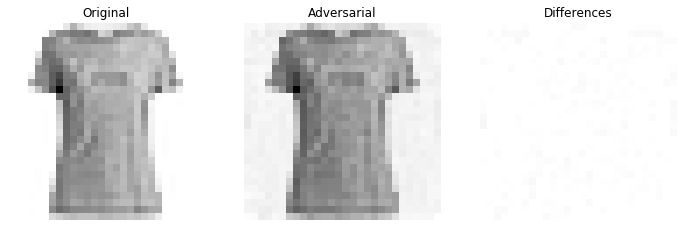

In [0]:
# Now we visualize the different between 
# a T-shirt classified as a T-shirt and
# a T-shirt classified as a bag
X_tshirt = X_tshirt.numpy().reshape(img_dim, img_dim)
X_adversarial = X_adversarial.numpy().reshape(img_dim, img_dim)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_tshirt, cmap='Greys')
plt.axis('off')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(X_adversarial, cmap='Greys')
plt.axis('off')
plt.title("Adversarial")

plt.subplot(1, 3, 3)
plt.imshow(X_adversarial - X_tshirt,
           cmap='Greys',
           vmin=np.min(X_tshirt),
           vmax=np.max(X_tshirt))
plt.axis('off')
plt.title("Differences")

# Part IV: Make the artificial neural network work "dream"

![alt text](https://drive.google.com/uc?export=view&id=1A8f3VtdNReZ8LZztCu-kXYdwy2626o6E)

More detail: https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html


In [0]:
#@title The following block contain the `deep_dream` function that will propagate all the learned pattern of neural network back to an input iamge (remember to run this)
@tf.function
def deep_dream_optimizing(dream_model, img, learning_rate):
  with tf.GradientTape() as tape:
    # This needs gradients relative to `img`
    # `GradientTape` only watches `tf.Variable`s by default
    tape.watch(img)
    # add batch dimension
    layer_activations = dream_model(tf.expand_dims(img, axis=0))
    # calculate activation of each layer
    losses = []
    for act in layer_activations:
      loss = tf.math.reduce_mean(act)
      losses.append(loss)
    loss = tf.reduce_sum(losses)
  # Calculate the gradient of the loss with respect to the pixels of the input image.
  gradients = tape.gradient(loss, img)
  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8
  # update images, note this is gradient ascent, not descent
  img = img + gradients * learning_rate
  return loss, img


# ====== Deep dream ====== #
def deep_dream(model,
               layers_name,
               img,
               n_epoch=100,
               learning_rate=0.01,
               octave_scale=1,
               octave_step=1):
  # add the batch dimension
  img = tf.convert_to_tensor(img, dtype='float32')
  base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  # Maximize the activations of these layers
  layers = [model.get_layer(name).output for name in layers_name]
  # Create the feature extraction model
  dream_model = keras.Model(inputs=model.input, outputs=layers)

  for n in range(max(octave_step, 1)):
    # resize the image
    if octave_scale > 1:
      new_shape = tf.cast(base_shape * (octave_scale**n), tf.int32)
      img = tf.image.resize(img, new_shape)
    # optimize the resized image
    for epoch in range(n_epoch):
      loss, img = deep_dream_optimizing(dream_model, img, learning_rate)
  return loss, img

Iter#100  Loss:15.2387
Iter#200  Loss:16.0690
Iter#300  Loss:16.9027
Iter#400  Loss:17.7415
Iter#500  Loss:18.5836
Iter#600  Loss:19.4261
Iter#700  Loss:20.2750
Iter#800  Loss:21.1381
Iter#900  Loss:22.0234
Iter#1000  Loss:22.9250
Iter#1100  Loss:23.8424
Iter#1200  Loss:24.7634


(-0.5, 27.5, 27.5, -0.5)

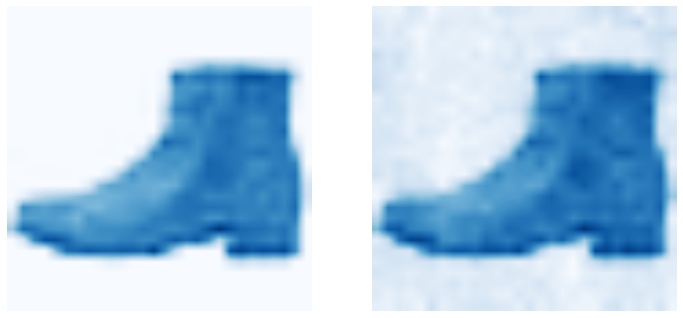

In [0]:
# This block assume you already trained a neural network "model" on F-MNIST dataset above
# Does our network dream out new fashion boot?
img = X_train[1]
images = [img]
for i in range(12):
  loss, img = deep_dream(model, ['L1', 'L2', 'L3'], img)
  images.append(img.numpy().reshape(img_dim, img_dim))
  print("Iter#%d  Loss:%.4f" % ((i + 1) * 100, loss.numpy()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images[0].reshape(img_dim, img_dim),
           cmap='Blues',
           interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(images[-1].reshape(img_dim, img_dim),
           cmap='Blues',
           interpolation='bilinear')
plt.axis('off')

## b) Using pretrained `InceptionV3` network (trained on ImageNet)

8192/6451 [======================================] - 0s 0us/step


(-0.5, 342.5, 419.5, -0.5)

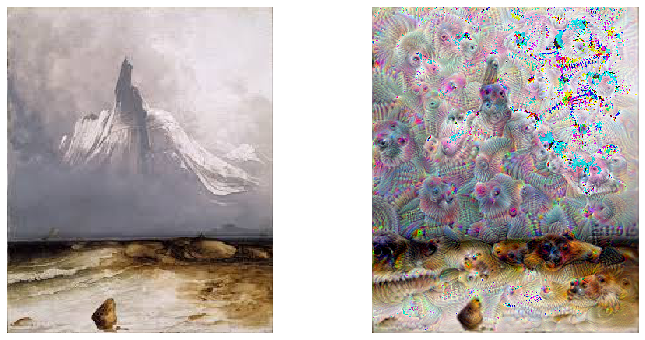

In [0]:
# ====== USing inception ====== #
# Try to play with different image, set of layers, octave, epoch and learning 
# in deep_dream function
model = keras.applications.InceptionV3(include_top=False, weights='imagenet')
# this will download my favourite image online, but if you run it in your local
# computer, you could pick any image
img = download_images()
img = tf.keras.applications.inception_v3.preprocess_input(img)
images = [img]
loss, img = deep_dream(model, ['mixed3', 'mixed5'],
                       img,
                       n_epoch=50,
                       octave_scale=1.3,
                       octave_step=3)
images.append(img.numpy())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# NOTE: remember to `deprocess` the image before showing it
plt.imshow(deprocess(images[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess(images[-1]))
plt.axis('off')